(cartes-statistiques-chapitre)=
# Cartes statistiques

<table>
  <tr>
    <td align="center">
      <a href="https://github.com/elisabethloranger">
        <img src="https://avatars.githubusercontent.com/u/90270981?v=4?s=100" width="100px;" alt=""/>
        <br /><sub><b>Élisabeth Loranger</b></sub>
      </a>
      <br />
        <a title="Contenu">🤔</a>
    </td>
    <td align="center">
      <a href="https://github.com/pbellec">
        <img src="https://avatars.githubusercontent.com/u/1670887?v=4?s=100" width="100px;" alt=""/>
        <br /><sub><b>Pierre bellec</b></sub>
      </a>
      <br />
        <a title="Contenu">🤔</a>
    </td>
  </tr>
</table>

```{warning}
Ce chapitre est en cours de développement. Il se peut que l'information soit incomplète, ou sujette à changement.
```
## Objectifs du cours

On va parler du modèle de régression pour générer des cartes statistiques cérébrales de groupe. Les statistiques de groupe permettent de combiner les mesures du cerveau de plusieurs individus et ainsi de contraster des groupes (ex. groupe de personnes jeunes et groupe de personnes âgées) ou bien de tester l'association avec une variable continue (ex. l'âge).

Les objectifs spécifiques du cours sont les suivants :
 * Régression linéaire.
 * Le modèle linéaire général.
 * Comparaisons multiples.

## Régression linéaire

### Variables

/home/pbellec/env/psy3018/lib/python3.8/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "
/home/pbellec/env/psy3018/lib/python3.8/site-packages/numpy/lib/npyio.py:2407: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  output = genfromtxt(fname, **kwargs)


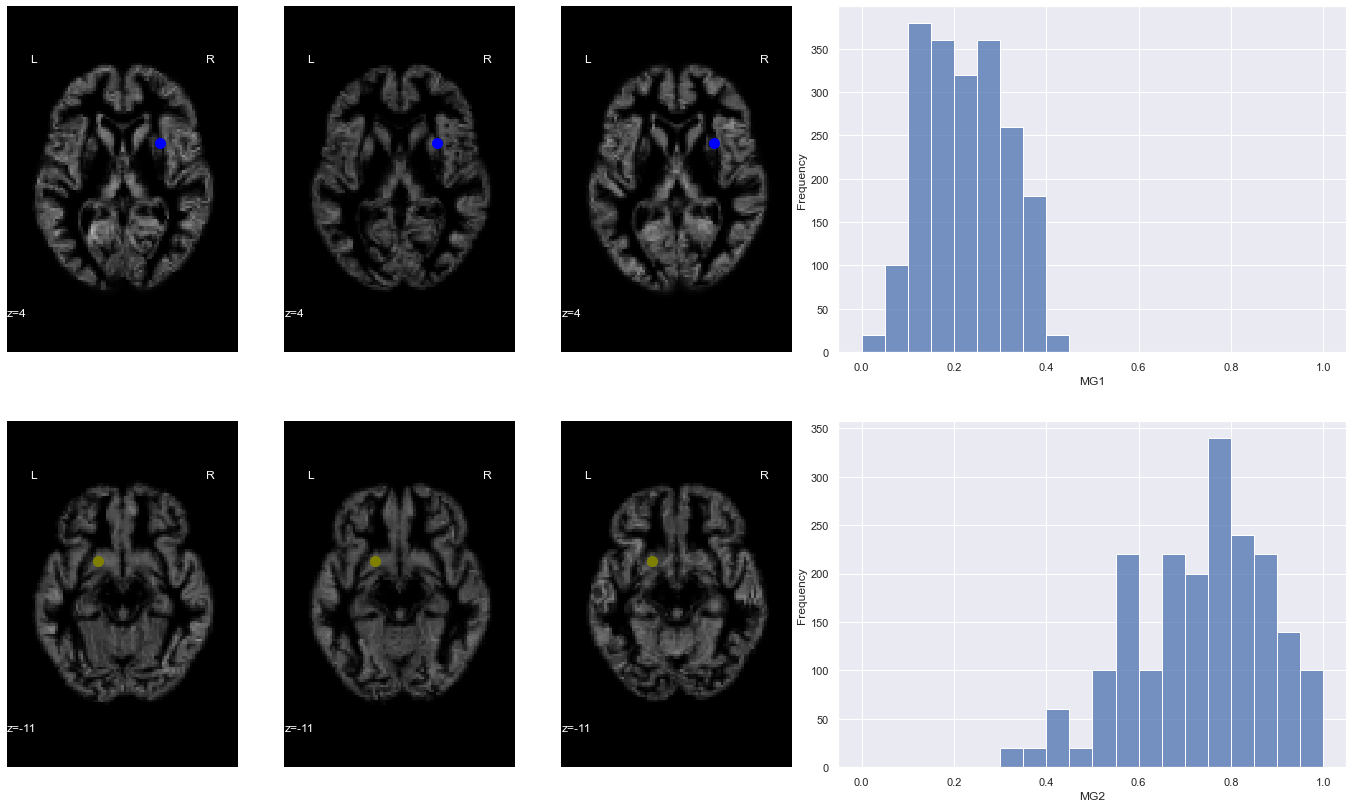

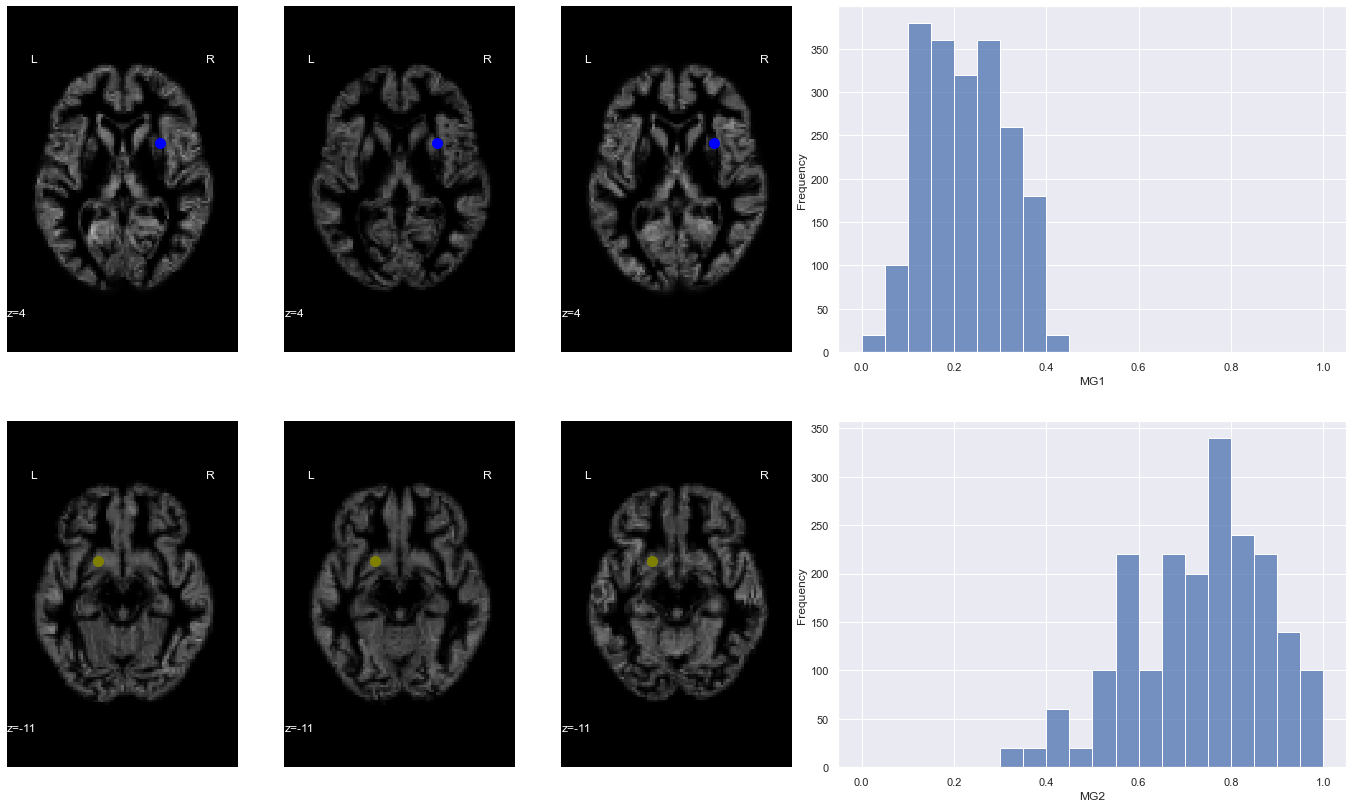

In [1]:
# Importer les librairies
import numpy as np
import matplotlib.pyplot as plt
from nilearn import datasets
from nilearn.input_data import NiftiMasker
from nilearn.image import get_data

# Charge les données
n_subjects = 100  
oasis_dataset = datasets.fetch_oasis_vbm(n_subjects=n_subjects)
gray_matter_map_filenames = oasis_dataset.gray_matter_maps
age = oasis_dataset.ext_vars['age'].astype(float)
sex = oasis_dataset.ext_vars['mf'] == b'F'

# On convertit les données en pandas dataframe
# Deux voxels intéressants ont été sélectionnés
import pandas as pd
coords = np.array([[ 29.,  10.,   4.], [-19.,   8., -11.]])
colors = ['blue', 'olive']

from nilearn import input_data
masker = input_data.NiftiSpheresMasker(coords)
gm = masker.fit_transform(gray_matter_map_filenames)
subject_label = [f'sub-{num}' for num in range(n_subjects)]
df = pd.DataFrame({
    "subject_label": subject_label,
    "age": age,
    "sexe": oasis_dataset.ext_vars['mf'],
    "MG1": gm[:, 0],
    "MG2": gm[:, 1]
    })

df["sexe"] = df["sexe"].replace([b'F', b'M'], value=['femelle', 'male'])

# On génère la Figure
from nilearn import plotting
import seaborn as sns
fig = plt.figure(figsize=(24, 14))

for i in range(0, 6):        
    nx = np.floor_divide(i, 3)
    ny = np.remainder(i, 3)
    ax = plt.subplot2grid((2, 5), (nx, ny), colspan=1)
    roi_img = plotting.plot_anat(
        gray_matter_map_filenames[i], cut_coords=[coords[nx][2]], figure=fig,
        axes=ax, display_mode='z', colorbar=False)
    roi_img.add_markers([coords[nx]], colors[nx], 100)

sns.set_theme(style="darkgrid")
ax = plt.subplot2grid((2, 5), (0, 3), colspan=2)
sns.histplot(
    df["MG1"], ax=ax, binwidth=0.05, binrange=[0, 1], stat='frequency')

ax = plt.subplot2grid((2, 5), (1, 3), colspan=2)
sns.histplot(
    df["MG2"], ax=ax, binwidth=0.05, binrange=[0, 1], stat='frequency')

from myst_nb import glue
glue("vbm-distribution-fig", fig, display=False)

```{glue:figure} vbm-distribution-fig
:figwidth: 800px
:name: vbm-distribution-fig
La position de deux voxels est illustrée avec un cercle bleu (haut) et olive (bas), de manière superposée avec des cartes de densité de matière grise pour différents sujets du jeu de données OASIS ([Marcus et al., 2010](https://dx.doi.org/10.1162%2Fjocn.2009.21407)). À droite, un histograme représente la distribution de la densité de matière grise pour le voxel correspondant, au travers de 100 sujets. Cette figure est adaptée d'un tutoriel de la librairie [nilearn](https://nilearn.github.io/auto_examples/05_glm_second_level/plot_oasis.html#sphx-glr-auto-examples-05-glm-second-level-plot-oasis-py) (cliquer sur + pour voir le code). Cette figure est distribuée sous license [CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/).
```
Les concepts présentés dans ce chapitre s’appliquent à la plupart des modalités d'imagerie vues dans le cours de façon plus ou moins identique. Mais afin de rendre les choses plus concrètes, nous allons nous intéresser à une analyse en morphométrie VBM à l'aide de l'IRM structurelle. Cette analyse utilise le jeu de données OASIS ([Marcus et al., 2010](https://dx.doi.org/10.1162%2Fjocn.2009.21407)). Des cartes de densité de matière grise pour les données OASIS sont disponibles via la librairie [nilearn](https://nilearn.github.io/modules/generated/nilearn.datasets.fetch_oasis_vbm.html). Pour chaque voxel, on dispose d'une mesure locale de densité de matière grise, qui varie entre 0 et 1. Comme toutes les images des 100 participants OASIS utilisés dans cet exemple ont été recalées dans un même espace stéréotaxique, on a donc pour chaque voxel une série de 100 mesures. Il s'agit de notre **variable dépendante**, car on va chercher à expliquer les variations de cette mesure au travers des sujets à l'aide d'autres variables, dites **prédicteurs**, et on va démarrer avec l'âge des participants qui varie de 20 ans à 90 ans.

### Modèle linéaire

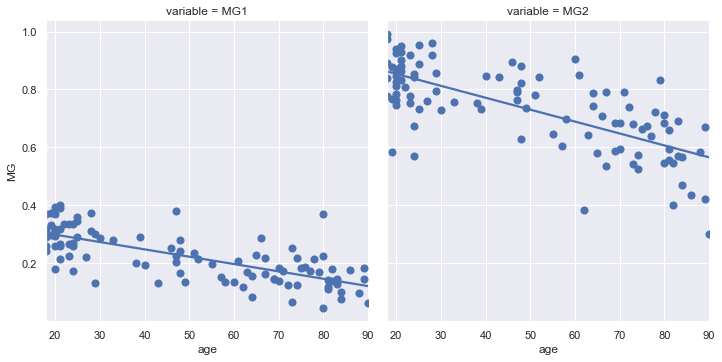

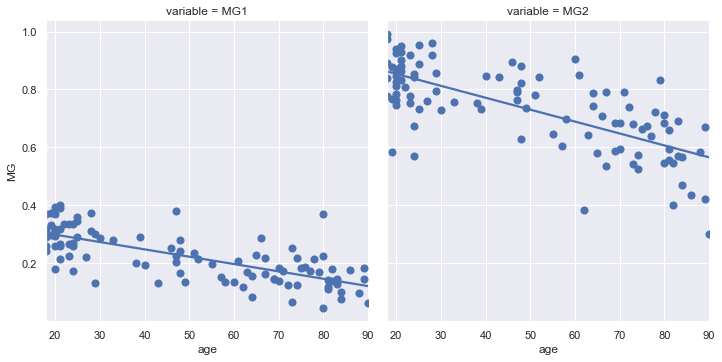

In [2]:
# On réorganise de DataFrame pour utiliser seaborn
df2 = df.melt(id_vars=["age", "sexe"], value_vars=["MG1", "MG2"], value_name="MG")
fig = sns.lmplot(x="age", y="MG", data=df2, col='variable',
           ci=None, scatter_kws={"s": 50, "alpha": 1})

# On colle la figure dans le jupyter book
from myst_nb import glue
glue("regression-vbm-fig", fig.fig, display=False)           

```{glue:figure} regression-vbm-fig
:figwidth: 800px
:name: regression-vbm-fig
 Régression linéaire, où la variable dépendante est la densité de matière grise pour un voxel, et le prédicteur est l'âge. Les valeurs de densité de matière grise proviennent de 100 sujets de la base de données OASIS ([Marcus et al., 2010](https://dx.doi.org/10.1162%2Fjocn.2009.21407)), et les deux voxels sont présentés dans la {numref}`vbm-distribution-fig` (voxel bleu à gauche, voxel olive à droite). La régression linéaire est réalisée à l'aide de la libraire [seaborn](https://seaborn.pydata.org) (cliquer sur + pour voir le code). Cette figure est distribuée sous license [CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/).
```
L'idée sous-jacente au modèle de régression est une équation, ou une sorte de loi, qui va prédire la variable dépendante, ici la densité de matière grise, à partir des prédicteurs, disons l'age. Mais, contrairement à une loi physique qui représente une dépendance exacte (dans un certain régime), cette loi ne capture qu'une fraction de la variance de notre mesure. La loi va donc incorporer un bruit, qui représente toutes les sources de variabilité que l'on ne peut pas capturer avec notre relation. La relation mathématique va prendre la forme suivante:

`densite_matiere_grise = b0 + b1 * age + e`

 * `densite_matiere_grise` est la densité de matière grise mesurée pour un voxel.
 * `age` est l'âge du participant de recherche.
 * `b0` est une valeur constante, appelée en anglais "intercept". Cette valeur est identique pour tous les sujets. Dans ce cas, elle représentrait la densité de matière grise observée à la naissance (`age=0`), en moyenne sur la population.
 * `b1` est une autre constante, qui dans ce cas mesure la réduction de matière grise par année de vie (en moyenne sur la population).
 * `e` est un bruit de mesure, qui capture toutes les variations de `densite_matiere_grise` que l'on ne peut pas expliquer avec `age`. Typiquement on suppose que la moyenne de `e` dans la population est `0`, et que la variance de `e` est identique pour tous les sujets, égale à $\sigma^2$.

 On ne connait évidemment pas les coefficients `b0` et `b1`, et on doit utiliser une procédure statistique pour les `estimer`, c'est à dire deviner (au mieux) leurs valeurs à partir des données dont on dispose. Par exemple, pour la région de couleur `olive` (graphe de droite dans {numref}`regression-vbm-fig`), on voit que l'on perd environ 25% de densité entre 20 ans et 90 ans, voir {numref}`regression-vbm-fig`. On perd donc environ 0.35% de densité de matière grise par an, soit `b1 ~ -0.0035`. En utilisant cette valeur et en remarquant que la densité de matière grise est d'à peu près `0.85` à `20` ans, on en déduit que la densité à la naissance devrait être `b0=0.92`. En pratique la procédure statistique va choisir les valeurs `b0` et `b1` pour minimiser l'amplitude des résidus de la régression:

 `residus = densite_matiere_grise - b0 - b1 * age`

 Une fois les coefficients `b0` et `b1` estimés, on peut tracer une droite qui représente les valeurs de densité de matière grise prédites à partir de l'âge des sujets, voir {numref}`regression-vbm-fig`. Si le modèle explique beaucoup de la variabilité de la variable dépendante, les points mesurés seront proches de la droite de prédiction.

### Analyse massivement univariée

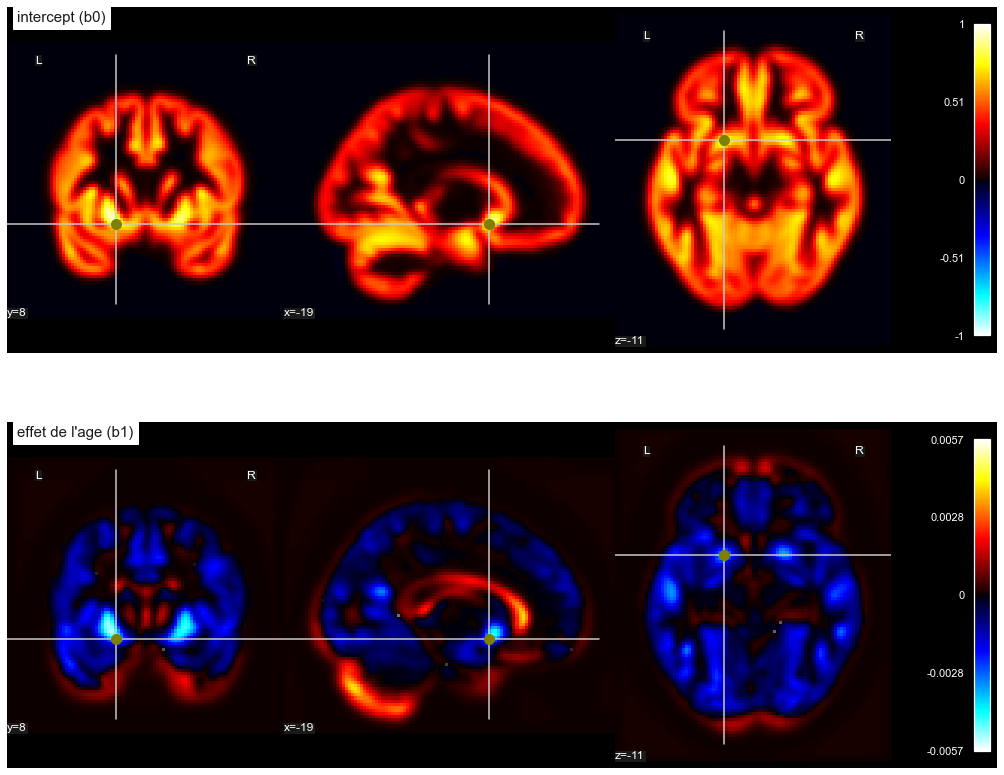

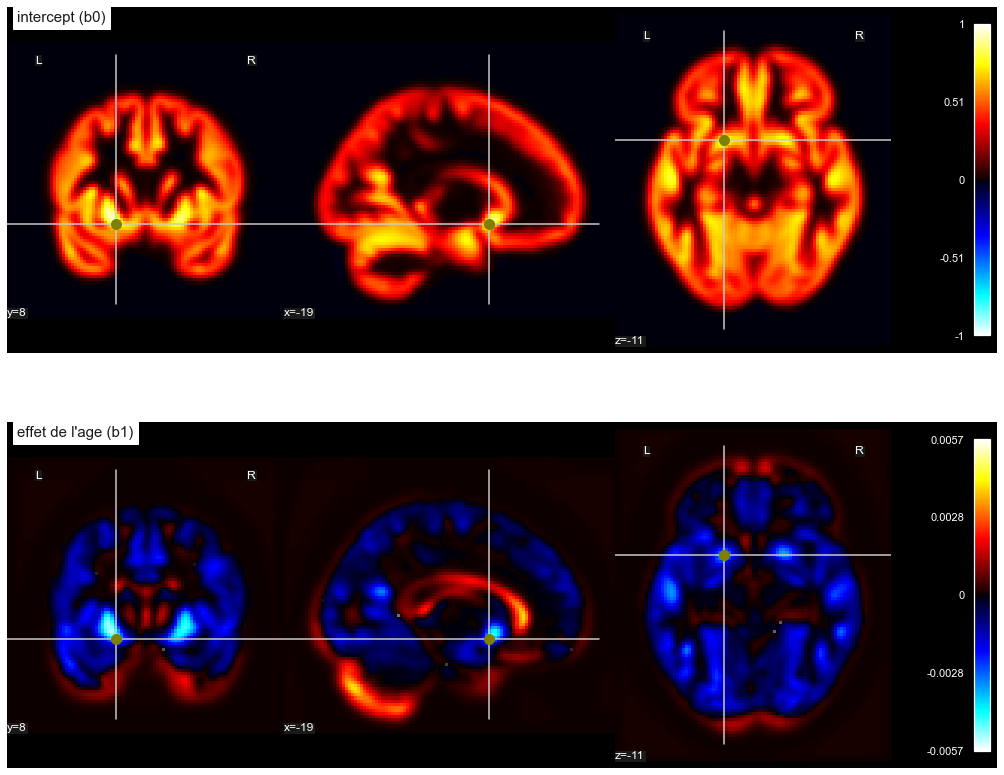

In [3]:
from nilearn.glm.second_level import make_second_level_design_matrix
design_df = df[["subject_label", "age"]].replace(['femelle', 'male'], value=[0, 1])
design_matrix = make_second_level_design_matrix(
    subject_label,
    design_df
    )
from nilearn.glm.second_level import SecondLevelModel
second_level_model = SecondLevelModel(smoothing_fwhm=5.0)
second_level_model = second_level_model.fit(gray_matter_map_filenames,
                                            design_matrix=design_matrix)
beta0 = second_level_model.compute_contrast(second_level_contrast="intercept", output_type="effect_size")
beta1 = second_level_model.compute_contrast(second_level_contrast="age", output_type="effect_size")

# On génère la Figure
from nilearn import plotting
import seaborn as sns
fig = plt.figure(figsize=(24, 14))

ax = plt.subplot2grid((2, 4), (0, 0), colspan=3)
roi_img = plotting.plot_stat_map(
    beta0, bg_img=gray_matter_map_filenames[0], cut_coords=coords[1], figure=fig,
    axes=ax, display_mode='ortho', colorbar=True, title='intercept (b0)')
roi_img.add_markers([coords[1]], colors[1], 100)

ax = plt.subplot2grid((2, 4), (1, 0), colspan=3)
roi_img = plotting.plot_stat_map(
    beta1, bg_img=gray_matter_map_filenames[0], cut_coords=coords[1], figure=fig,
    axes=ax, display_mode='ortho', colorbar=True, title='effet de l\'age (b1)')
roi_img.add_markers([coords[1]], colors[1], 100)

# On colle la figure dans le jupyter book
from myst_nb import glue
glue("b0-b1-fig", fig, display=False)           

```{glue:figure} b0-b1-fig
:figwidth: 600px
:name: b0-b1-fig
 Cartes de paramètres statistiques dans une régression linéaire massivement univariée. Première ligne: intercept `b0`, deuxième ligne: effet linéaire de l'âge `b1`. Cette figure est adaptée d'un tutoriel de la librairie [nilearn](https://nilearn.github.io/auto_examples/05_glm_second_level/plot_oasis.html#sphx-glr-auto-examples-05-glm-second-level-plot-oasis-py) (cliquer sur + pour voir le code). Cette figure est distribuée sous license [CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/).
```
On a pour l'instant présenté le modèle de régression pour deux voxels seulement. Mais une carte VBM peut inclure des centaines de milliers de voxels. Les logiciels de neuroimagerie permettent d'effectuer systématiquement une régression linéaire pour l'ensemble des voxels, simultanément. Dans ce cas, on estime deux paramètres pour chaque voxel: `b0` (l'intercept) et `b1` (l'effet de l'âge). On va donc générer deux cartes statistiques séparées, voir {numref}`b0-b1-fig`. Ces deux cartes récapitulent donc des milliers de modèles de régression différents. Comme les régressions effectuées à chaque voxel sont indépendante les unes des autres, on parle de modèle univarié, par opposition à un modèle multivarié qui cherche à combiner les valeurs obtenues à différents voxels. De plus, comme on fait un très grand nombre de régressions en même temps, on parle de régression **massivement univariée**.

```{admonition} Statistiques et multimodalité
:class: tip
:name: stats-multimodales
Le modèle de régression est appliqué pour plusieurs modalités de neuroimagerie. Dans cet exemple, on s'intéresse à la VBM. Mais le même modèle fonctionne dès lors qu'on a une série de cartes pour différents sujets, et peut par exemple être utilisé en [IRMf](https://nilearn.github.io/auto_examples/05_glm_second_level/plot_oasis.html#sphx-glr-auto-examples-05-glm-second-level-plot-oasis-py) ou bien en TEP. Le même type de modèle peut aussi s'appliquer à des mesures prises sur des récepteurs en imagerie optique, ou des mesures moyennes sur un faisceau de fibres en IRMd. Le modèle de régression est partout!
```

## Modèle linéaire général

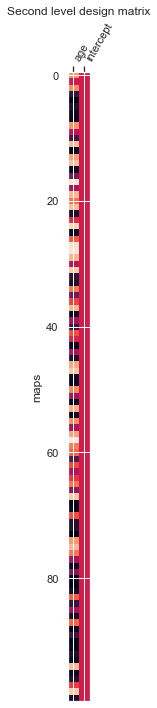

In [4]:
from nilearn.plotting import plot_design_matrix
ax = plot_design_matrix(design_matrix)
ax.set_title('Second level design matrix', fontsize=12)
ax.set_ylabel('maps')
plt.tight_layout()
plt.show()                                                

### Variables
Ici, on a une représentation différente. Cette représentation a l’avantage de permettre de voir plusieurs « courbes » simultanément de manière claire. En mathématique, on appel ce type de représentation des « matrices ».

On a plusieurs tableaux dans cette représentation. Dans le premier, on a une seule colonne avec plein de lignes, ensuite on a un tableau qui a le même nombre de lignes que le premier mais avec 4 colonnes et un dernier tableau avec seulement 3 lignes et une colonne. Dans les deux premiers tableaux, chaque ligne correspond à un sujet et chaque colonne correspond à un type de variable. Il faut préciser que l’on n’a pas pris le scan cérébral complet pour le premier tableau. En fait, on a pris le même voxel chez tous les participants (à l’aide d’un recalage).

Les tons de gris représentent en fait des valeurs numériques. Or, pour aider à la visualisation, nous avons utilisé une échelle de couleurs qui représente ces valeurs.

Le premier tableau représente les valeurs des cartes cérébrales, qui sont les valeurs que l’on cherche à expliquer. Les tableaux à droite du « = » représentent les valeurs qui permettent d’expliquer les valeurs des cartes cérébrales.
Ici, on a deux vecteurs qui cotent pour le sexe de nos participants et un autre qui représente le score de dépression pour chacune de nos observations (dans le premier tableau).

Cette représentation est plutôt simple, nous avons une formule ressemblant à y = mx+b, donnant une relation linéaire. À gauche on a le y, c’est ce qu’on cherche à modéliser. Le tableau à droite, on a les paramètres explicatifs. Pour le sexe, on a mis un 1 quand le sexe correspondait au sujet et un 0 lorsqu’il ne correspondait pas. Ainsi, on remarque que, ici, la moitié des sujets étaient des hommes et l’autre moitié étaient des femmes. La variable de dépression est mesurée à l’aide de questionnaires et le score est représenté ici dans la 3e colonne du 2e tableau. Le 3e tableau représente l’amplitude des différentes facteurs explicatifs que l’on peut changer afin de mieux expliquer nos valeurs IRMf. Ceci revient à la même chose qui a été vue dans les graphiques présentés plus tôt. Ainsi, le score que l’on tente d’expliquer pour un sujet (une ligne) sera obtenu à l’aide de la formule suivante : le score « homme » du sujet x le coefficient « homme » + le score « femme » du sujet x le coefficient « femme » + le score « dépression » du sujet x le coefficient « dépression ». Ce qui reste et qui n,est pas expliqué par cette formule correspondra aux résidus. Tel que vu plus tôt, la formule avec les coefficients auront comme but de minimiser les résidus le plus possible.

Ici, on a un exemple un peu plus complexe. À gauche, on a ce qu’on vient de voir et au centre, on a séparé le score de dépression pour les femmes et celui pour les hommes.

Dans l’exemple précédent, le coefficient de dépression était le même pour les hommes et les femmes. On prétendait alors que le niveau d’influence de la dépression sur le cerveau des femmes et celui des hommes était pareil. Dans le tableau du centre, nous attribuions un coefficient différent aux scores de dépression des hommes et celui des femmes, prétendant alors que l’influence de la dépression sur le cerveau pourrait différer en fonction du sexe. Ici, on test alors le principe d’interaction. En statistiques classiques, on pourrait comparer ce modèle a une ANOVA.

En réalité, ce modèle se nomme le modèle linéaire général car on peut pas mal tout tester. Si on veut faire un test-t, on peut le faire à l’aide de ce modèle.

Si on prend deux coefficients de notre modèle, on peut regarder la différence entre ces deux coefficients. Par exemple, on peut regarder si l’influence de la dépression sur le cerveau chez les femmes (ß1) diffère de celle de la dépression sur le cerveau chez les hommes (ß2).

Ca donnerait quelque chose comme ça et nous donnerait une carte de contraste statistique qui nous permet de contraster l’influence de la dépression chez les femmes et chez les hommes.
Ce qui va changer d’un voxel à l’autre ce n’est pas les facteurs explicatifs, ce sont les y (les mesures d’activation). On n’aura ainsi pas les mêmes bêtas et les mêmes valeurs de contraste. C’est aussi appelé une approche massivement univariée.

On peut parler d’une analyse de niveau 1 pour les analyses individuelles et les analyses de niveau 2 pour les analyses de groupe.

## Conclusion

En générale quand on parle de l’IRMf ou même de la VBM, on trouve des blobs qui présentent des effets significatifs. Ce qui est important de se rappeler est toute la série d’étapes qui mènent à ce type de carte.
1. La première, l’hypothèse psychologique : 	On avait commencé le cours avec ces deux tâches avec les visages qui expriment les émotions et des stimuli contrôles. Notre est hypothèse est que ce sont les visages qui expliquent le patron d’activation observé.  
2. Ensuite, on a des hypothèses au niveau neuronal : On émet des hypothèses au sujet du type de réponse neuronale observé. En IRMf, on émet l’hypothèse que l’activation atteint son plafond quand la stimulation est débutée et qu’elle retombe à 0 une fois le bloc terminé.
3. Finalement, on a des hypothèses hémodynamiques : On va supposer que l’activité BOLD enregistrée en IRMf va correspondre à l’activité neuronale.

À la fin, on aura des étapes d’analyses d’images, de recalage, de débruitage et de modélisation statistique.

Ainsi, il y a beaucoup de choses, de choix et d’hypothèses qui vont derrière ce petit blob rouge qui ressort dans des cartes statistiques.